In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../artifacts/sentiment_analysis.csv')

In [3]:
data.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


# **Data Preprocessing**

In [4]:
data.shape

(7920, 3)

In [5]:
data.duplicated().sum()

np.int64(0)

In [6]:
data.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

## **Text Preprocessing**

In [7]:
import re
import string

In [9]:
x_data = data['tweet']
y_data = data['label']

**Convert upper case to lower case**

In [12]:
x_data = x_data.apply(lambda x: " ".join(x.lower() for x in x.split()))

**Remove Links**

In [15]:
x_data = x_data.apply(lambda x: " ".join(re.sub(r'^https:?\/\/.*[\r\n]*', '', x, flags=re.MULTILINE) for x in x.split()))

**Remove Punctuations**

In [20]:
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [21]:
x_data = x_data.apply(remove_punctuations)

**Remove Numbers**

In [26]:
x_data = x_data.str.replace(r'\d+', '', regex=True)

**Remove Stopwords**

In [28]:
import nltk

In [30]:
nltk.download('stopwords', download_dir='../static/model')

[nltk_data] Downloading package stopwords to ../static/model...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [36]:
with open('../static/model/corpora/stopwords/english', 'r') as file:
    stop_words = file.read().splitlines()

In [38]:
x_data = x_data.apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

**Stemming**

In [40]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

In [41]:
x_data = x_data.apply(lambda x: " ".join(ps.stem(x) for x in x.split()))

In [43]:
x_data

0       fingerprint pregnanc test android app beauti c...
1       final transpar silicon case thank uncl yay son...
2       love would go talk makememori unplug relax iph...
3       im wire know im georg made way iphon cute dave...
4       amaz servic appl wont even talk question unles...
                              ...                        
7915    live loud lol liveoutloud selfi smile soni mus...
7916    would like wish amaz day make everi minut coun...
7917    help love year old neighbor ipad morn made rea...
7918    final got smart pocket wifi stay connect anyti...
7919    appl barcelona appl store bcn barcelona travel...
Name: tweet, Length: 7920, dtype: str

# **Building Vocabulary**

In [45]:
from collections import Counter
vocab = Counter()

In [46]:
for sentence in x_data:
    vocab.update(sentence.split())

In [53]:
print(vocab.most_common(5))
print("\nVocab length : ", len(vocab))

[('iphon', 4073), ('appl', 2876), ('samsung', 1395), ('new', 1137), ('phone', 1015)]

Vocab length :  19066


In [55]:
tokens = [key for key in vocab if vocab[key] > 10]
print("\nVocab length : ", len(tokens))


Vocab length :  1152


In [57]:
def save_vocabulary(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w', encoding="utf-8")
    file.write(data)
    file.close()

save_vocabulary(tokens, '../static/model/vocabulary.txt')

# **Train Test Split**

In [59]:
from sklearn.model_selection import train_test_split

In [64]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

print("Train size : ", len(x_train))
print("Test size  : ", len(x_test))

Train size :  6336
Test size  :  1584


# **Vectorization**

In [65]:
def vectorizer(ds, vocabulary):
    vectorized_list = []
    for sentence in ds:
        sentence_list = np.zeros(len(vocabulary))

        for i in range(len(vocabulary)):
            if vocabulary[i] in sentence.split():
                sentence_list[i] = 1
                
        vectorized_list.append(sentence_list)
        
    vectorized_list_new = np.asarray(vectorized_list, dtype=np.float32)
    return vectorized_list_new                

In [66]:
vectorized_x_train = vectorizer(x_train, tokens)
vectorized_x_test = vectorizer(x_test, tokens)

---

In [70]:
y_train.value_counts()

label
0    4700
1    1636
Name: count, dtype: int64

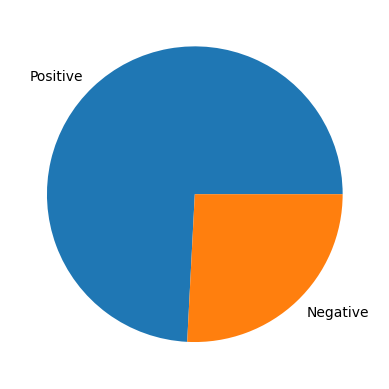

In [71]:
plt.pie(np.array([y_train.value_counts()[0], y_train.value_counts()[1]]), labels=['Positive', 'Negative'])
plt.show()

# **Handle Imbalanced Dataset**

In [72]:
from imblearn.over_sampling import SMOTE

In [73]:
smote = SMOTE()
vectorized_x_train_smote, y_train_smote = smote.fit_resample(vectorized_x_train, y_train)
print("vectorized_x_train_smote size : ", len(vectorized_x_train_smote))
print("y_train_smote                 : ", len(y_train_smote))

vectorized_x_train_smote size :  9400
y_train_smote                 :  9400


In [74]:
y_train_smote.value_counts()

label
0    4700
1    4700
Name: count, dtype: int64

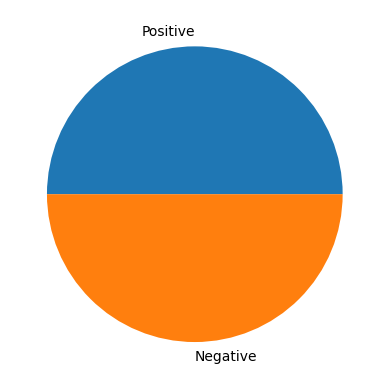

In [75]:
plt.pie(np.array([y_train_smote.value_counts()[0], y_train_smote.value_counts()[1]]), labels=['Positive', 'Negative'])
plt.show()

# **Model Training and Evaluation**

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [90]:
def training_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    pr = round(precision_score(y_act, y_pred), 3)
    rec = round(recall_score(y_act, y_pred), 3)
    f1 = round(f1_score(y_act, y_pred), 3)
    print(f'\nTraining Scores:\n\tAccuracy = {acc}\n\tPrecision = {pr}\n\tRecall = {rec}\n\tF1-Score = {f1}')

def testing_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    pr = round(precision_score(y_act, y_pred), 3)
    rec = round(recall_score(y_act, y_pred), 3)
    f1 = round(f1_score(y_act, y_pred), 3)
    print(f'\nTesting Scores:\n\tAccuracy = {acc}\n\tPrecision = {pr}\n\tRecall = {rec}\n\tF1-Score = {f1}')

## **Logistic Regression**

In [82]:
lr = LogisticRegression()
lr.fit(vectorized_x_train_smote, y_train_smote)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [91]:
# Training accuracy
y_train_pred = lr.predict(vectorized_x_train_smote)
training_scores(y_train_smote, y_train_pred)

# Testing accuracy
y_test_pred = lr.predict(vectorized_x_test)
testing_scores(y_test, y_test_pred)


Training Scores:
	Accuracy = 0.938
	Precision = 0.916
	Recall = 0.965
	F1-Score = 0.94

Testing Scores:
	Accuracy = 0.883
	Precision = 0.717
	Recall = 0.864
	F1-Score = 0.784


## **Naive Bayes**

In [92]:
mnb = MultinomialNB()
mnb.fit(vectorized_x_train_smote, y_train_smote)

,"alpha alpha: float or array-like of shape (n_features,), default=1.0Additive (Laplace/Lidstone) smoothing parameter(set alpha=0 and force_alpha=True, for no smoothing).",1.0
,"force_alpha force_alpha: bool, default=TrueIf False and alpha is less than 1e-10, it will set alpha to1e-10. If True, alpha will remain unchanged. This may causenumerical errors if alpha is too close to 0... versionadded:: 1.2.. versionchanged:: 1.4 The default value of `force_alpha` changed to `True`.",True
,"fit_prior fit_prior: bool, default=TrueWhether to learn class prior probabilities or not.If false, a uniform prior will be used.",True
,"class_prior class_prior: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None


In [93]:
# Training accuracy
y_train_pred = mnb.predict(vectorized_x_train_smote)
training_scores(y_train_smote, y_train_pred)

# Testing accuracy
y_test_pred = mnb.predict(vectorized_x_test)
testing_scores(y_test, y_test_pred)


Training Scores:
	Accuracy = 0.908
	Precision = 0.871
	Recall = 0.957
	F1-Score = 0.912

Testing Scores:
	Accuracy = 0.871
	Precision = 0.669
	Recall = 0.944
	F1-Score = 0.783


## **Decision Tree**

In [95]:
dt = DecisionTreeClassifier()
dt.fit(vectorized_x_train_smote, y_train_smote)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",None
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the curre

In [96]:
# Training accuracy
y_train_pred = dt.predict(vectorized_x_train_smote)
training_scores(y_train_smote, y_train_pred)

# Testing accuracy
y_test_pred = dt.predict(vectorized_x_test)
testing_scores(y_test, y_test_pred)


Training Scores:
	Accuracy = 1.0
	Precision = 1.0
	Recall = 0.999
	F1-Score = 1.0

Testing Scores:
	Accuracy = 0.842
	Precision = 0.677
	Recall = 0.687
	F1-Score = 0.682


## **Random Forest**

In [97]:
rf = RandomForestClassifier()
rf.fit(vectorized_x_train_smote, y_train_smote)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [98]:
# Training accuracy
y_train_pred = rf.predict(vectorized_x_train_smote)
training_scores(y_train_smote, y_train_pred)

# Testing accuracy
y_test_pred = rf.predict(vectorized_x_test)
testing_scores(y_test, y_test_pred)


Training Scores:
	Accuracy = 1.0
	Precision = 1.0
	Recall = 1.0
	F1-Score = 1.0

Testing Scores:
	Accuracy = 0.886
	Precision = 0.771
	Recall = 0.767
	F1-Score = 0.769


## **Support Vector Machine**

In [99]:
svm = SVC()
svm.fit(vectorized_x_train_smote, y_train_smote)

,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [100]:
# Training accuracy
y_train_pred = svm.predict(vectorized_x_train_smote)
training_scores(y_train_smote, y_train_pred)

# Testing accuracy
y_test_pred = svm.predict(vectorized_x_test)
testing_scores(y_test, y_test_pred)


Training Scores:
	Accuracy = 0.977
	Precision = 0.961
	Recall = 0.995
	F1-Score = 0.977

Testing Scores:
	Accuracy = 0.888
	Precision = 0.742
	Recall = 0.833
	F1-Score = 0.785


# **Save the Model**

In [101]:
import pickle

In [102]:
with open('../static/model/model.pickle', 'wb') as file:
    pickle.dump(lr, file)